In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import sklearn
import george
from george import kernels
from george.modeling import Model
import emcee
import corner

# changing default font sizes and family
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Cambria' #'serif' Cambria, Times New Roman, Georgia

SN = pd.read_csv('data/LSQ12gdj_photometry.csv')
SN

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
0,LSQ12gdj,56237.50000,18.300,NaN,F,NaN,NaN,NaN,"2012ATel.4566....1C,Latest Supernovae"
1,LSQ12gdj,56242.05339,17.487,0.012,F,i,QUEST,ESO Schmidt,2015ApJS..219...13W
2,LSQ12gdj,56242.05846,17.184,0.008,F,r,QUEST,ESO Schmidt,2015ApJS..219...13W
3,LSQ12gdj,56242.06586,17.037,0.008,F,V,QUEST,ESO Schmidt,2015ApJS..219...13W
4,LSQ12gdj,56242.07164,17.006,0.009,F,B,QUEST,ESO Schmidt,2015ApJS..219...13W
...,...,...,...,...,...,...,...,...,...
599,LSQ12gdj,56679.76200,19.351,NaN,T,U,UVOT,Swift,2014Ap&SS.354...89B
600,LSQ12gdj,56679.76270,19.717,NaN,T,B,UVOT,Swift,2014Ap&SS.354...89B
601,LSQ12gdj,56679.76460,20.389,NaN,T,UVW2,UVOT,Swift,2014Ap&SS.354...89B
602,LSQ12gdj,56679.76620,18.782,NaN,T,V,UVOT,Swift,2014Ap&SS.354...89B


In [2]:
time = SN['time']
mag = SN['magnitude']
error = SN['e_magnitude']

UVW2band = np.where(SN['band'] == 'UVW2')[0]
UVM2band = np.where(SN['band'] == 'UVM2')[0]
UVW1band = np.where(SN['band'] == 'UVW1')[0]
Uband = np.where(SN['band'] == 'U')[0]
Bband = np.where(SN['band'] == 'B')[0]
Vband = np.where(SN['band'] == 'V')[0]
Gband = np.where(SN['band'] == 'G')[0]
Rband = np.where(SN['band'] == 'R')[0]
rband = np.where(SN['band'] == 'r')[0]
Iband = np.where(SN['band'] == 'I')[0]
iband = np.where(SN['band'] == 'i')[0]
Zband = np.where(SN['band'] == 'Z')[0]

band_idxs = [UVW2band, UVM2band, UVW1band, Uband, Bband, Vband, Gband, Rband, rband, Iband, iband, Zband]
labels = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'G', 'R', 'r', 'I', 'i', 'Z']

print('Number of points: ', len(SN['band']))
print('Sum of points in bands excluding 1 NaN: ', len(iband)+len(rband)+len(Vband)+len(Bband)+
      len(Uband)+len(Zband)+len(Gband)+len(Iband)+len(UVW1band)+len(UVW2band)+len(UVM2band)+len(Rband))

print(min(time))

Number of points:  604
Sum of points in bands excluding 1 NaN:  603
56237.5


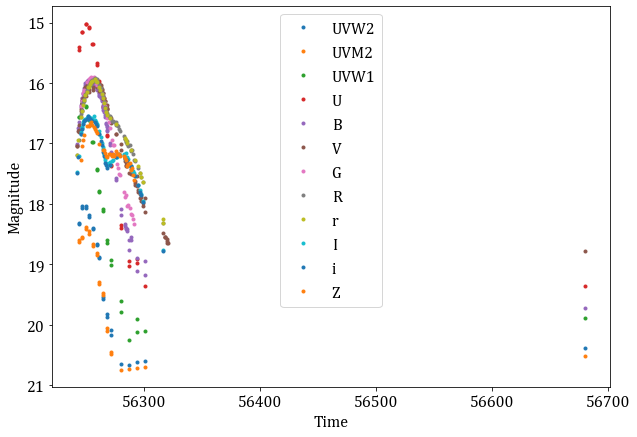

In [3]:
fig = plt.figure(figsize=(10, 7))
for idx, val in enumerate(band_idxs):
    plt.plot(time[val], mag[val], 'o', ms=3, label=labels[idx])
#plt.xlim([56200, 56340])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [4]:
peakbright_idx = np.argmin(mag[Rband])
rise = np.asarray(mag[Rband])[:peakbright_idx]
decline = np.asarray(mag[Rband])[peakbright_idx:]
time = time - min(time)
rise_time = np.asarray(time[Rband])[:peakbright_idx]
decline_time = np.asarray(time[Rband])[peakbright_idx:]

rise_coeff = np.polyfit(rise_time, rise, 2)
decline_coeff = np.polyfit(decline_time, decline, 1)

rise_fit = rise_coeff[0]*rise_time**2 + rise_coeff[1]*rise_time + rise_coeff[2]
decline_fit = decline_time*decline_coeff[0] + decline_coeff[1]

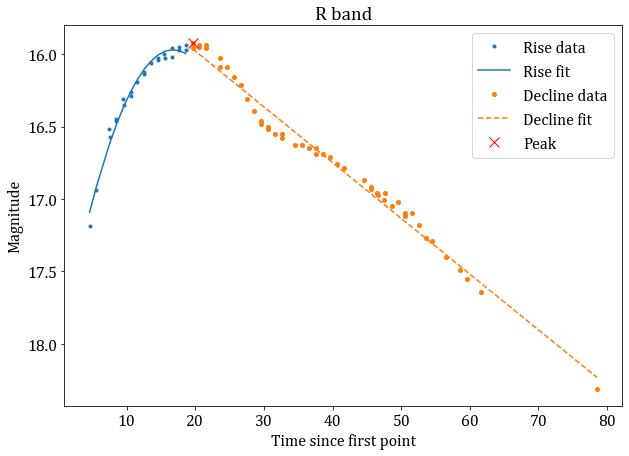

In [5]:
fig = plt.figure(figsize=(10, 7))
#plt.plot(time[Rband], mag[Rband], 'o', ms=3, label='R')
plt.plot(rise_time, rise, 'C0o', ms=3, label='Rise data')
plt.plot(rise_time, rise_fit, 'C0-', ms=4, label='Rise fit')
plt.plot(decline_time, decline, 'C1o', ms=4, label='Decline data')
plt.plot(decline_time, decline_fit, 'C1--', ms=4, label='Decline fit')
plt.plot(np.asarray(time[Rband])[peakbright_idx], np.asarray(mag[Rband])[peakbright_idx], 'rx', ms=10, label='Peak')
plt.title('R band')
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [6]:
k = kernels.ExpSquaredKernel(metric=1.0)

In [7]:
class MeanModel(Model):
    parameter_names = ('peak', 'r0', 'r1', 'r2', 'd0', 'd1', 'pt') # peak, rise1, decline1, peak_time
    def set_vector(self, p):
        self.peak, self.r0, self.r1, self.r2, self.d0, self.d1, self.pt = p
    def get_value(self, t):
        # want out a magnitude, given a time
        # before the time where peak mag is reached
        # follow a parabolic curve
        # after peak is reached (in time)
        # follow a linear curve
        
        #rise_time = t[:self.pt]
        #decline_time = t[self.pt:]
        
        mag_arr = np.array([])
        for i in t:
            if i < self.pt: # before peak time
                mag = self.r0*i**2 + self.r1*i + self.r2
            else: # after peak time
                mag = self.d0*i + self.d1
            mag_arr = np.append(mag_arr, mag)
        return mag_arr
            
peak_init = np.asarray(mag[Rband])[peakbright_idx]
r0_init, r1_init, r2_init = rise_coeff
d0_init, d1_init = decline_coeff
pt_init = rise_time[-1]

gp = george.GP(mean=MeanModel(peak=peak_init, r0=r0_init, r1=r1_init, r2=r2_init,
                              d0=d0_init, d1=d1_init, pt=pt_init), kernel=k)

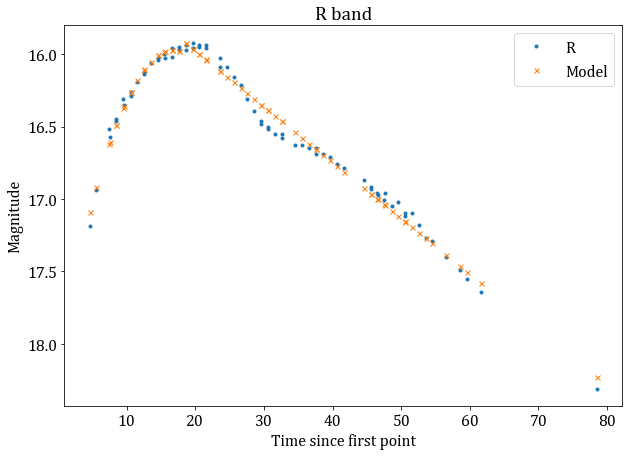

In [8]:
def get_value(p, t):
    # want out a magnitude, given a time
    # before the time where peak mag is reached
    # follow a parabolic curve
    # after peak is reached (in time)
    # follow a linear curve
        
    #rise_time = t[:self.pt]
    #decline_time = t[self.pt:]
    peak, r0, r1, r2, d0, d1, pt = p
        
    mag_arr = np.array([])
    for i in t:
        if i < pt: # before peak time
            mag = r0*i**2 + r1*i + r2
        else: # after peak time
            mag = d0*i + d1
        mag_arr = np.append(mag_arr, mag)
    return mag_arr

p = [15.92, 0.007582968060367829, -0.2542875928805066, 18.101827967845036, 
     0.03852595895807011, 15.20822188452947, 18.599999999998545]

mag_arr = get_value(p, time[Rband])


fig = plt.figure(figsize=(10, 7))
plt.plot(time[Rband], mag[Rband], 'o', ms=3, label='R')
plt.plot(time[Rband], mag_arr, 'x', ms=5, label='Model')
plt.title('R band')
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [9]:
gp.get_parameter_dict()

OrderedDict([('mean:peak', 15.92),
             ('mean:r0', 0.007582968060367829),
             ('mean:r1', -0.2542875928805066),
             ('mean:r2', 18.101827967845036),
             ('mean:d0', 0.03852595895807011),
             ('mean:d1', 15.20822188452947),
             ('mean:pt', 18.599999999998545),
             ('kernel:metric:log_M_0_0', 0.0)])

In [10]:
def lnprob(p):
    if (p[0] < 10) or (p[0] > 20): # prior on peak
        return -np.inf
    if (p[1] < 0) or (p[1] > 0.1): # prior on r0
        return -np.inf
    if (p[2] < -1) or (p[2] > 0): # prior on r1
        return -np.inf
    if (p[3] < 0) or (p[3] > 100): # prior on r2
        return -np.inf
    if (p[4] < 0) or (p[4] > 1.0): # prior on d0
        return -np.inf
    if (p[5] < 0) or (p[5] > 100): # prior on d1
        return -np.inf
    if (p[6] < 0) or (p[6] > 40): # prior on peak_time
        return -np.inf
    if (p[7] < -10.0) or (p[7] > 10.0): # prior on lambda (metric)
        return -np.inf
    
    gp.set_parameter_vector(p)
    return gp.log_likelihood(mag[Rband][::2], quiet=True) + gp.log_prior()

In [11]:
# from "hyperparameters"
gp.compute(time[Rband][::2])

nwalkers, ndim = 32, len(gp)
nsteps, nburnin = 4000, 400
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = gp.get_parameter_vector() + np.random.randn(nwalkers, ndim)*1e-2

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, nburnin, progress=True)

print("Running production chain")
chain = sampler.run_mcmc(p0, nsteps, progress=True)

  0%|          | 1/400 [00:00<00:41,  9.52it/s]

Running burn-in


  0%|          | 2/4000 [00:00<03:49, 17.43it/s]

Running production chain


100%|██████████| 4000/4000 [03:39<00:00, 18.22it/s]


Text(0.5, 0, 'Step')

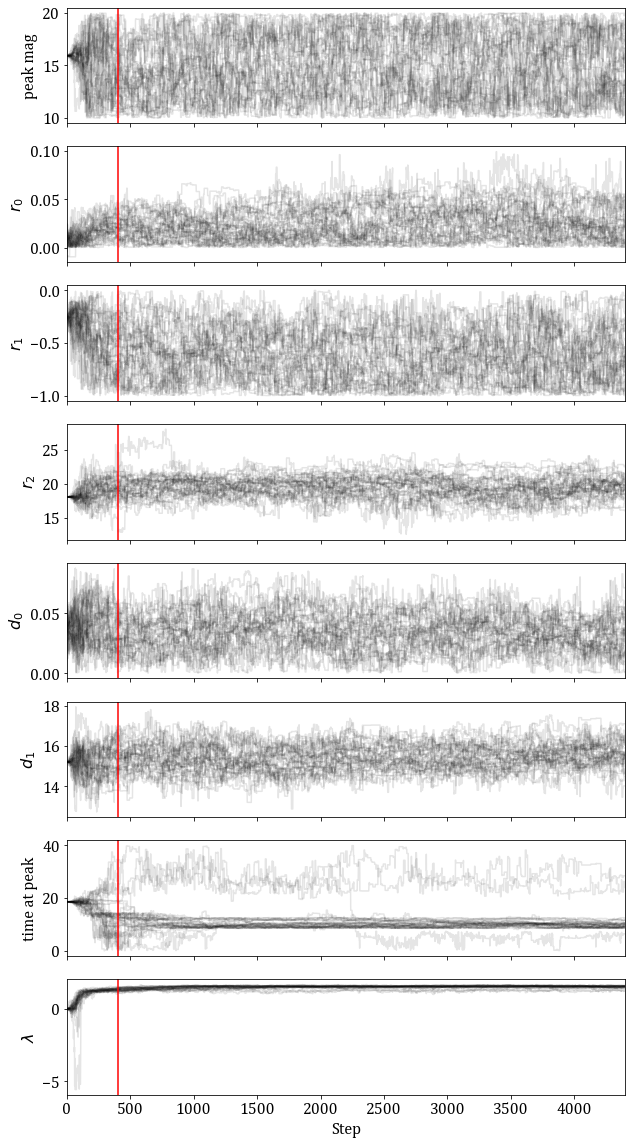

In [12]:
samp = sampler.get_chain()

labels = [r'peak mag', r'$r_0$', r'$r_1$', r'$r_2$', r'$d_0$', r'$d_1$', 'time at peak', r'$\lambda$']

fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samp[:,:,i], color='k', alpha=0.1 )
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, nburnin+nsteps)
    ax.axvline(nburnin, color='red')
ax.set_xlabel('Step')

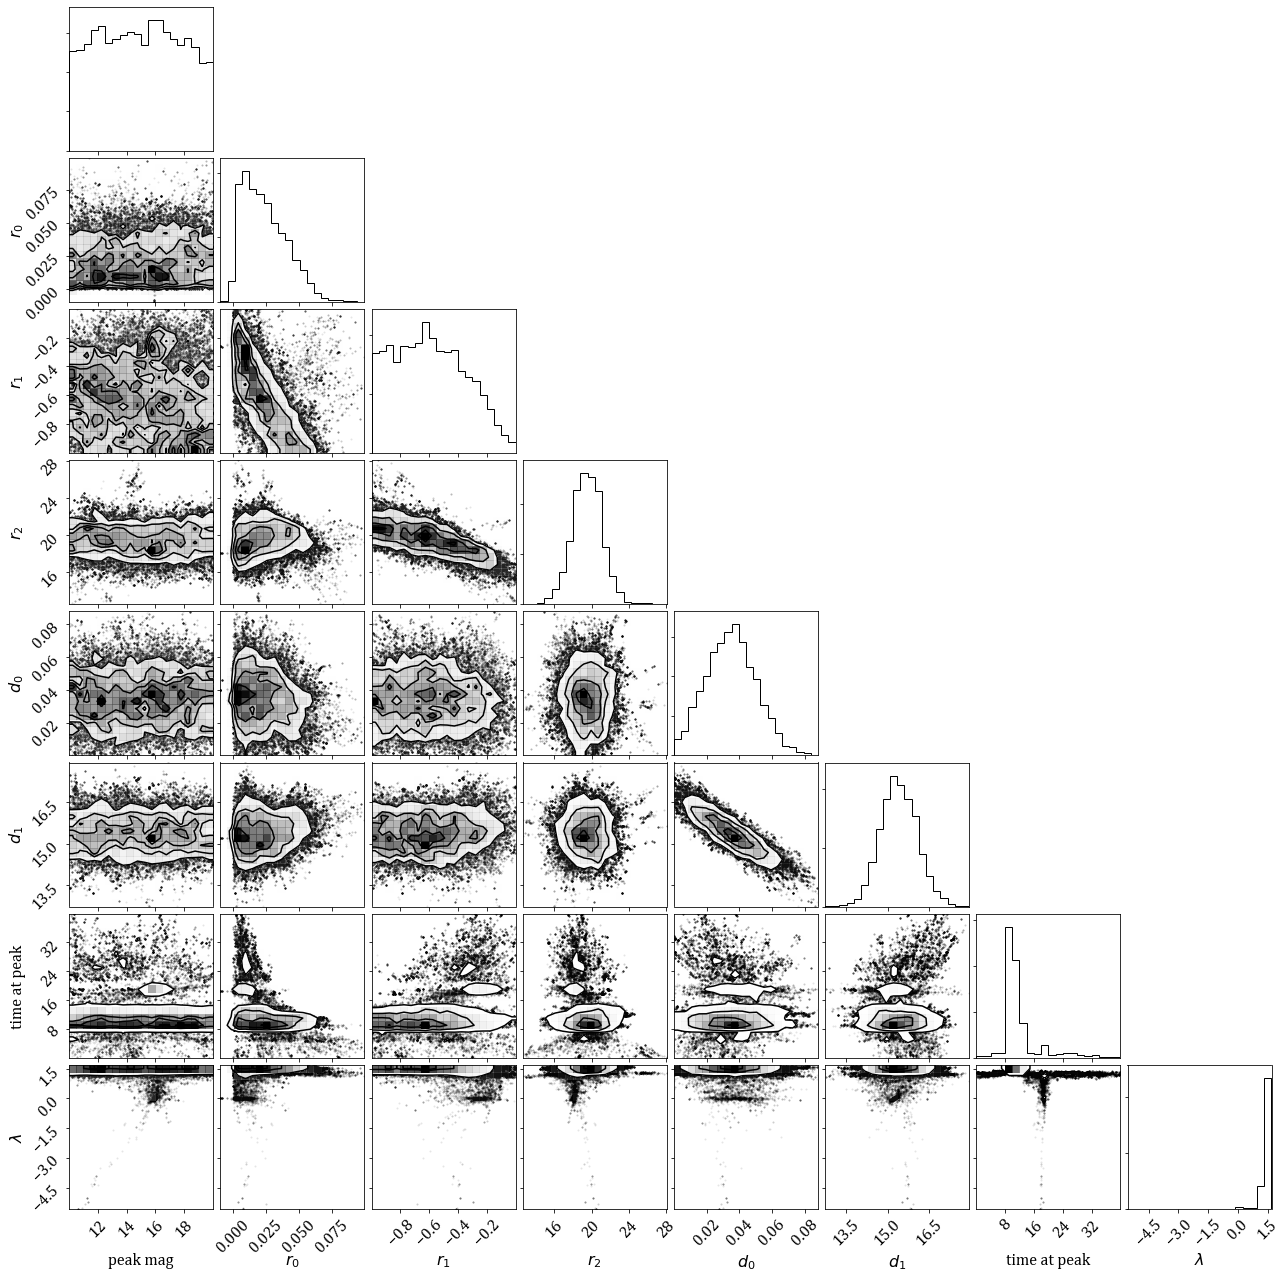

In [13]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=labels) 

Text(0.5, 1.0, 'Posterior models over GP conditioned data')

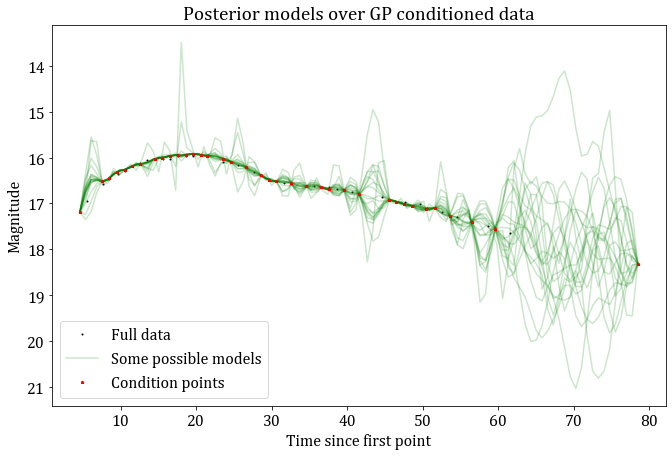

In [14]:
x = np.linspace(min(time[Rband]), max(time[Rband]), 100)

fig = plt.figure(figsize=(11,7))
plt.plot(time[Rband], mag[Rband], '.k', ms=2, label='Full data')
for i in range(20):
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(20, 220) # explicitly excluding burn-in
    gp.set_parameter_vector(sampler.chain[w, n])

    samp = gp.sample_conditional(mag[Rband][::2], x)
    if i == 0:
        plt.plot(x, samp, 'g', alpha=0.2, label='Some possible models')
    else:
        plt.plot(x, samp, 'g', alpha=0.2)
plt.plot(time[Rband][::2], mag[Rband][::2], '*r', ms=3, label='Condition points')
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Posterior models over GP conditioned data')